### Загрузим и обработаем датасет

In [1]:
from  load_data import Load_Process_Dataset

D = Load_Process_Dataset('adult')
D.start_load()

Start processing dataset adult from UCI.
Aready downloaded.
adult (32561, 15) (16281, 15) (32561, 15)
Numerical (32561, 6)
Categorical (32561, 8)
Processing and Saving adult Successfully!
adult
Total 48842
Train 32561
Test 16281
Num 6
Cat 9


### train VAE


#### params

In [15]:
LR = 1e-3
WD = 0
D_TOKEN = 4
TOKEN_BIAS = True

In [16]:
N_HEAD = 1
FACTOR = 32
NUM_LAYERS = 2

In [ ]:
import torch
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

In [35]:
from train_vae import VAE_main

vae_train = VAE_main(name = 'adult', LR = 1e-3, WD = 0, D_TOKEN = 4, N_HEAD = 1, FACTOR = 32, NUM_LAYERS = 2)

Device: cuda


In [36]:
vae_train.tabsyn_vae_main(device = my_device, num_epochs = 2000)

No NaNs in numerical features, skipping
self.category_embeddings.weight.shape=torch.Size([104, 4])
self.category_embeddings.weight.shape=torch.Size([104, 4])


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch: 0, beta = 0.010000, Train MSE: 4.399094, Train CE:2.268144, Train KL:0.519363, Val MSE:2.748934, Val CE:2.269849, Train ACC:0.161681, Val ACC:0.164827
epoch: 100, beta = 0.010000, Train MSE: 0.005627, Train CE:0.018905, Train KL:3.046936, Val MSE:0.005574, Val CE:0.018568, Train ACC:0.997629, Val ACC:0.997734
epoch: 200, beta = 0.010000, Train MSE: 0.003333, Train CE:0.005364, Train KL:2.318560, Val MSE:0.003430, Val CE:0.005419, Train ACC:0.999143, Val ACC:0.999106
epoch: 300, beta = 0.010000, Train MSE: 0.002563, Train CE:0.002696, Train KL:2.050753, Val MSE:0.002623, Val CE:0.002660, Train ACC:0.999600, Val ACC:0.999591
Learning rate updated: 0.00095
epoch: 400, beta = 0.004900, Train MSE: 0.001244, Train CE:0.001283, Train KL:1.998581, Val MSE:0.001281, Val CE:0.001350, Train ACC:0.999771, Val ACC:0.999795
epoch: 500, beta = 0.002401, Train MSE: 0.000625, Train CE:0.000656, Train KL:2.093331, Val MSE:0.000555, Val CE:0.000595, Train ACC:0.999886, Val ACC:0.999898
epoch: 600,

###train TabSyn

In [37]:
from train_tabsyn import tabsyn_main
tabsyn_main(my_device, 'adult', 4000)

model
MLPDiffusion(
  (proj): Linear(in_features=60, out_features=1024, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): SiLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=60, bias=True)
  )
  (map_noise): PositionalEmbedding()
  (time_embed): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)
the number of parameters 10616892
Epoch:0, Loss:0.7826796480502299
Epoch:100, Loss:0.22250397327505603
Epoch:200, Loss:0.8243791915517281
Epoch:300, Loss:0.8220251654016053
Epoch:400, Loss:0.8237168357759702
Epoch:500, Loss:0.824042617355751
Epoch:600, Loss:0.823579074982354
Early stopping
Time:  587.0287897586823


In [39]:
from transform_data import preprocess
def get_input_generate(dataname):
    # dataname = args.dataname

    curr_dir = 'tabsyn'#os.path.dirname(os.path.abspath(__file__))
    dataset_dir = f'data/{dataname}'
    ckpt_dir = f'model'

    with open(f'{dataset_dir}/info.json', 'r') as f:
        info = json.load(f)

    task_type = info['task_type']


    # ckpt_dir = f'{curr_dir}/ckpt/{dataname}'

    _, _, categories, d_numerical, num_inverse, cat_inverse = preprocess(dataset_dir, task_type = task_type, inverse = True)

    embedding_save_path = 'model/train_z.npy'#f'{curr_dir}/vae/ckpt/{dataname}/train_z.npy'
    train_z = torch.tensor(np.load(embedding_save_path)).float()

    train_z = train_z[:, 1:, :]

    B, num_tokens, token_dim = train_z.size()
    in_dim = num_tokens * token_dim

    train_z = train_z.view(B, in_dim)
    pre_decoder = Decoder_model(2, d_numerical, categories, 4, n_head = 1, factor = 32)

    decoder_save_path = 'model/decoder.pt'#f'{curr_dir}/vae/ckpt/{dataname}/decoder.pt'
    pre_decoder.load_state_dict(torch.load(decoder_save_path))

    info['pre_decoder'] = pre_decoder
    info['token_dim'] = token_dim

    return train_z, curr_dir, dataset_dir, ckpt_dir, info, num_inverse, cat_inverse

In [48]:
import torch

import argparse
import warnings
import time

from train_tabsyn import MLPDiffusion, Model
from train_vae import Decoder_model

randn_like=torch.randn_like

SIGMA_MIN=0.002
SIGMA_MAX=80
rho=7
S_churn= 1
S_min=0
S_max=float('inf')
S_noise=1
@torch.no_grad()
def split_num_cat_target(syn_data, info, num_inverse, cat_inverse, device):
    task_type = info['task_type']

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    n_num_feat = len(num_col_idx)
    n_cat_feat = len(cat_col_idx)

    if task_type == 'regression':
        n_num_feat += len(target_col_idx)
    else:
        n_cat_feat += len(target_col_idx)


    pre_decoder = info['pre_decoder']
    token_dim = info['token_dim']

    syn_data = syn_data.reshape(syn_data.shape[0], -1, token_dim)

    norm_input = pre_decoder(torch.tensor(syn_data))
    x_hat_num, x_hat_cat = norm_input

    syn_cat = []
    for pred in x_hat_cat:
        syn_cat.append(pred.argmax(dim = -1))

    syn_num = x_hat_num.cpu().numpy()
    syn_cat = torch.stack(syn_cat).t().cpu().numpy()

    syn_num = num_inverse(syn_num)
    syn_cat = cat_inverse(syn_cat)

    if info['task_type'] == 'regression':
        syn_target = syn_num[:, :len(target_col_idx)]
        syn_num = syn_num[:, len(target_col_idx):]

    else:
        print(syn_cat.shape)
        syn_target = syn_cat[:, :len(target_col_idx)]
        syn_cat = syn_cat[:, len(target_col_idx):]

    return syn_num, syn_cat, syn_target

def recover_data(syn_num, syn_cat, syn_target, info):

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']


    idx_mapping = info['idx_mapping']
    idx_mapping = {int(key): value for key, value in idx_mapping.items()}

    syn_df = pd.DataFrame()

    if info['task_type'] == 'regression':
        for i in range(len(num_col_idx) + len(cat_col_idx) + len(target_col_idx)):
            if i in set(num_col_idx):
                syn_df[i] = syn_num[:, idx_mapping[i]]
            elif i in set(cat_col_idx):
                syn_df[i] = syn_cat[:, idx_mapping[i] - len(num_col_idx)]
            else:
                syn_df[i] = syn_target[:, idx_mapping[i] - len(num_col_idx) - len(cat_col_idx)]


    else:
        for i in range(len(num_col_idx) + len(cat_col_idx) + len(target_col_idx)):
            if i in set(num_col_idx):
                syn_df[i] = syn_num[:, idx_mapping[i]]
            elif i in set(cat_col_idx):
                syn_df[i] = syn_cat[:, idx_mapping[i] - len(num_col_idx)]
            else:
                syn_df[i] = syn_target[:, idx_mapping[i] - len(num_col_idx) - len(cat_col_idx)]

    return syn_df
def sample_step(net, num_steps, i, t_cur, t_next, x_next):

    x_cur = x_next
    # Increase noise temporarily.
    gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
    t_hat = net.round_sigma(t_cur + gamma * t_cur)
    x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)
    # Euler step.

    denoised = net(x_hat, t_hat).to(torch.float32)
    d_cur = (x_hat - denoised) / t_hat
    x_next = x_hat + (t_next - t_hat) * d_cur

    # Apply 2nd order correction.
    if i < num_steps - 1:
        denoised = net(x_next, t_next).to(torch.float32)
        d_prime = (x_next - denoised) / t_next
        x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    return x_next

def sample(net, num_samples, dim, num_steps = 50, device = 'cuda:0'):
    latents = torch.randn([num_samples, dim], device=device)

    step_indices = torch.arange(num_steps, dtype=torch.float32, device=latents.device)

    sigma_min = max(SIGMA_MIN, net.sigma_min)
    sigma_max = min(SIGMA_MAX, net.sigma_max)

    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (
                sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])])

    x_next = latents.to(torch.float32) * t_steps[0]

    with torch.no_grad():
        for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
            x_next = sample_step(net, num_steps, i, t_cur, t_next, x_next)

    return x_next

def sample_main(dataname = 'adult', device = 'cuda', steps = None):
    # dataname = args.dataname
    # device = args.device
    # steps = args.steps
    save_path = 'sample/sample.csv'

    train_z, _, _, ckpt_path, info, num_inverse, cat_inverse = get_input_generate(dataname)
    in_dim = train_z.shape[1]

    mean = train_z.mean(0)

    denoise_fn = MLPDiffusion(in_dim, 1024).to(device)

    model = Model(denoise_fn = denoise_fn, hid_dim = train_z.shape[1]).to(device)

    model.load_state_dict(torch.load(f'{ckpt_path}/model.pt'))

    '''
        Generating samples
    '''
    start_time = time.time()

    num_samples = train_z.shape[0]
    sample_dim = in_dim

    x_next = sample(model.denoise_fn_D, num_samples, sample_dim)
    x_next = x_next * 2 + mean.to(device)

    syn_data = x_next.float().cpu().numpy()
    syn_num, syn_cat, syn_target = split_num_cat_target(syn_data, info, num_inverse, cat_inverse, device)

    syn_df = recover_data(syn_num, syn_cat, syn_target, info)

    idx_name_mapping = info['idx_name_mapping']
    idx_name_mapping = {int(key): value for key, value in idx_name_mapping.items()}
    if not os.path.exists(f'sample'):
        os.makedirs(f'sample')
    syn_df.rename(columns = idx_name_mapping, inplace=True)
    syn_df.to_csv(save_path, index = False)

    end_time = time.time()
    print('Time:', end_time - start_time)

    print('Saving sampled data to {}'.format(save_path))


In [49]:
sample_main()

No NaNs in numerical features, skipping
(32561, 9)
Time: 17.570500373840332
Saving sampled data to sample/sample.csv


#### Сравнение на классификаторе

In [42]:
pip install prdc

In [14]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import logging
from prdc import compute_prdc
from tqdm import tqdm

CATEGORICAL = "categorical"
CONTINUOUS = "continuous"

_MODELS = {
    'binclass': [
        {
            'class': XGBClassifier, # 36
            'kwargs': {
                 'n_estimators': [10, 50, 100],
                 'min_child_weight': [1, 10],
                 'max_depth': [5, 10, 20],
                 'gamma': [0.0, 1.0],
                 'objective': ['binary:logistic'],
                 'nthread': [-1],
                 'tree_method': ['gpu_hist']
            },
        }

    ]
    }

def feat_transform(data, info, label_encoder = None, encoders = None, cmax = None, cmin = None):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    num_cols = len(num_col_idx + cat_col_idx + target_col_idx)
    features = []

    if not encoders:
        encoders = dict()
    for idx in range(num_cols):
        col = data[:, idx]

        if idx in target_col_idx:

            if info['task_type'] != 'regression':

                if not label_encoder:
                    label_encoder = LabelEncoder()
                    label_encoder.fit(col)

                encoded_labels = label_encoder.transform(col)
                labels = encoded_labels
            else:
                col = col.astype(np.float32)
                labels = col.astype(np.float32)

            continue

        if idx in num_col_idx:
            col = col.astype(np.float32)

            if not cmin:
                cmin = col.min()

            if not cmax:
                cmax = col.max()

            if cmin >= 0 and cmax >= 1e3:
                feature = np.log(np.maximum(col, 1e-2))

            else:
                feature = (col - cmin) / (cmax - cmin) * 5

        elif idx in cat_col_idx:
            encoder = encoders.get(idx)
            col = col.reshape(-1, 1)
            if encoder:
                feature = encoder.transform(col)
            else:
                encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                encoders[idx] = encoder
                feature = encoder.fit_transform(col)


        features.append(feature)
    features = np.column_stack(features)
    return features, labels, label_encoder, encoders, cmax, cmin


def prepare_ml_problem(train, test, info):
    # test_X, test_y, label_encoder, encoders = feat_transform(test, info)
    # train_X, train_y, _, _ = feat_transform(train, info, label_encoder, encoders)

    train_X, train_y, label_encoder, encoders, cmax, cmin = feat_transform(train, info)
    test_X, test_y, _, _ , _, _ = feat_transform(test, info, label_encoder, encoders, cmax, cmin)

    total_train_num = train_X.shape[0]
    val_num = int(total_train_num / 9)

    total_train_idx = np.arange(total_train_num)
    np.random.shuffle(total_train_idx)
    train_idx = total_train_idx[val_num:]
    val_idx = total_train_idx[:val_num]

    val_X, val_y = train_X[val_idx], train_y[val_idx]
    train_X, train_y = train_X[train_idx], train_y[train_idx]

    model = _MODELS[info['task_type']]

    return train_X, train_y, val_X, val_y, test_X, test_y, model

class FeatureMaker:

    def __init__(self, metadata, label_column='label', label_type='int', sample=50000):
        self.columns = metadata['columns']
        self.label_column = label_column
        self.label_type = label_type
        self.sample = sample
        self.encoders = dict()

    def make_features(self, data):
        data = data.copy()
        np.random.shuffle(data)
        data = data[:self.sample]

        features = []
        labels = []

        for index, cinfo in enumerate(self.columns):
            col = data[:, index]
            if cinfo['name'] == self.label_column:
                if self.label_type == 'int':
                    labels = col.astype(int)
                elif self.label_type == 'float':
                    labels = col.astype(float)
                else:
                    assert 0, 'unkown label type'
                continue

            if cinfo['type'] == CONTINUOUS:
                cmin = cinfo['min']
                cmax = cinfo['max']
                if cmin >= 0 and cmax >= 1e3:
                    feature = np.log(np.maximum(col, 1e-2))

                else:
                    feature = (col - cmin) / (cmax - cmin) * 5

            else:
                if cinfo['size'] <= 2:
                    feature = col

                else:
                    encoder = self.encoders.get(index)
                    col = col.reshape(-1, 1)
                    if encoder:
                        feature = encoder.transform(col)
                    else:
                        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                        self.encoders[index] = encoder
                        feature = encoder.fit_transform(col)

            features.append(feature)

        features = np.column_stack(features)

        return features, labels


def _prepare_ml_problem(train, val, test, metadata, eval):
    fm = FeatureMaker(metadata)
    x_trains, y_trains = [], []

    for i in train:
        x_train, y_train = fm.make_features(i)
        x_trains.append(x_train)
        y_trains.append(y_train)

    x_val, y_val = fm.make_features(val)
    if eval is None:
        x_test = None
        y_test = None
    else:
        x_test, y_test = fm.make_features(test)
    model = _MODELS[metadata['problem_type']]

    return x_trains, y_trains, x_val, y_val, x_test, y_test, model


def _weighted_f1(y_test, pred):
    report = classification_report(y_test, pred, output_dict=True)
    classes = list(report.keys())[:-3]
    proportion = [  report[i]['support'] / len(y_test) for i in classes]
    weighted_f1 = np.sum(list(map(lambda i, prop: report[i]['f1-score']* (1-prop)/(len(classes)-1), classes, proportion)))
    return weighted_f1


@ignore_warnings(category=ConvergenceWarning)
def _evaluate_binary_classification(train, test, info):
    x_trains, y_trains, x_valid, y_valid, x_test, y_test, classifiers = prepare_ml_problem(train, test, info)

    unique_labels = np.unique(y_trains)

    best_f1_scores = []
    best_weighted_scores = []
    best_auroc_scores = []
    best_acc_scores = []
    best_avg_scores = []

    for model_spec in classifiers:

        model_class = model_spec['class']
        model_kwargs = model_spec.get('kwargs', dict())
        model_repr = model_class.__name__

        unique_labels = np.unique(y_trains)

        param_set = list(ParameterGrid(model_kwargs))

        results = []
        for param in tqdm(param_set):
            model = model_class(**param)

            try:
                model.fit(x_trains, y_trains)
            except ValueError:
                pass

            if len(unique_labels) == 1:
                pred = [unique_labels[0]] * len(x_valid)
                pred_prob = np.array([1.] * len(x_valid))
            else:
                pred = model.predict(x_valid)
                pred_prob = model.predict_proba(x_valid)

            binary_f1 = f1_score(y_valid, pred, average='binary')
            weighted_f1 = _weighted_f1(y_valid, pred)
            acc = accuracy_score(y_valid, pred)
            precision = precision_score(y_valid, pred, average='binary')
            recall = recall_score(y_valid, pred, average='binary')
            macro_f1 = f1_score(y_valid, pred, average='macro')

            # auroc
            size = 2
            rest_label = set(range(size)) - set(unique_labels)
            tmp = []
            j = 0
            for i in range(size):
                if i in rest_label:
                    tmp.append(np.array([0] * y_valid.shape[0])[:,np.newaxis])
                else:
                    try:
                        tmp.append(pred_prob[:,[j]])
                    except:
                        tmp.append(pred_prob[:, np.newaxis])
                    j += 1
            roc_auc = roc_auc_score(np.eye(size)[y_valid], np.hstack(tmp))

            results.append(
                {
                    "name": model_repr,
                    "param": param,
                    "binary_f1": binary_f1,
                    "weighted_f1": weighted_f1,
                    "roc_auc": roc_auc,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "macro_f1": macro_f1
                }
            )


        # test the best model
        results = pd.DataFrame(results)
        results['avg'] = results.loc[:, ['binary_f1', 'weighted_f1', 'roc_auc']].mean(axis=1)
        best_f1_param = results.param[results.binary_f1.idxmax()]
        best_weighted_param = results.param[results.weighted_f1.idxmax()]
        best_auroc_param = results.param[results.roc_auc.idxmax()]
        best_acc_param = results.param[results.accuracy.idxmax()]
        best_avg_param = results.param[results.avg.idxmax()]


        def _calc(best_model):
            best_scores = []

            best_model.fit(x_trains, y_trains)

            if len(unique_labels) == 1:
                pred = [unique_labels[0]] * len(x_test)
                pred_prob = np.array([1.] * len(x_test))
            else:
                pred = best_model.predict(x_test)
                pred_prob = best_model.predict_proba(x_test)

            binary_f1 = f1_score(y_test, pred, average='binary')
            weighted_f1 = _weighted_f1(y_test, pred)
            acc = accuracy_score(y_test, pred)
            precision = precision_score(y_test, pred, average='binary')
            recall = recall_score(y_test, pred, average='binary')
            macro_f1 = f1_score(y_test, pred, average='macro')

            # auroc
            size = 2
            rest_label = set(range(size)) - set(unique_labels)
            tmp = []
            j = 0
            for i in range(size):
                if i in rest_label:
                    tmp.append(np.array([0] * y_test.shape[0])[:,np.newaxis])
                else:
                    try:
                        tmp.append(pred_prob[:,[j]])
                    except:
                        tmp.append(pred_prob[:, np.newaxis])
                    j += 1
            try:
                roc_auc = roc_auc_score(np.eye(size)[y_test], np.hstack(tmp))
            except ValueError:
                tmp[1] = tmp[1].reshape(20000, 1)
                roc_auc = roc_auc_score(np.eye(size)[y_test], np.hstack(tmp))

            best_scores.append(
                {
                    "name": model_repr,
                    # "param": param,
                    "binary_f1": binary_f1,
                    "weighted_f1": weighted_f1,
                    "roc_auc": roc_auc,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "macro_f1": macro_f1
                }
            )

            return pd.DataFrame(best_scores)
        def _df(dataframe):
            return {
                "name": model_repr,
                "binary_f1": dataframe.binary_f1.values[0],
                "roc_auc": dataframe.roc_auc.values[0],
                "weighted_f1": dataframe.weighted_f1.values[0],
                "accuracy": dataframe.accuracy.values[0],
            }

        best_f1_scores.append(_df(_calc(model_class(**best_f1_param))))
        best_weighted_scores.append(_df(_calc(model_class(**best_weighted_param))))
        best_auroc_scores.append(_df(_calc(model_class(**best_auroc_param))))
        best_acc_scores.append(_df(_calc(model_class(**best_acc_param))))
        best_avg_scores.append(_df(_calc(model_class(**best_avg_param))))

    return best_f1_scores, best_weighted_scores, best_auroc_scores, best_acc_scores, best_avg_scores

@ignore_warnings(category=ConvergenceWarning)
def compute_diversity(train, fake):
    nearest_k = 5
    if train.shape[0] >= 50000:
        num = np.random.randint(0, train.shape[0], 50000)
        real_features = train[num]
        fake_features_lst = [i[num] for i in fake]
    else:
        num = train.shape[0]
        real_features = train[:num]
        fake_features_lst = [i[:num] for i in fake]
    scores = []
    for i, data in enumerate(fake_features_lst):
        fake_features = data
        metrics = compute_prdc(real_features=real_features,
                        fake_features=fake_features,
                        nearest_k=nearest_k)
        metrics['i'] = i
        scores.append(metrics)
    return pd.DataFrame(scores).mean(axis=0), pd.DataFrame(scores).std(axis=0)

_EVALUATORS = {
    'binclass': _evaluate_binary_classification,
    # 'multiclass': _evaluate_multi_classification,
    # 'regression': _evaluate_regression
}

def get_evaluator(problem_type):
    return _EVALUATORS[problem_type]


def compute_scores(train, test, synthesized_data, metadata, eval):
    a, b, c = _EVALUATORS[metadata['problem_type']](train=train, test=test, fake=synthesized_data, metadata=metadata, eval=eval)
    if eval is None:
        return a.mean(axis=0), a.std(axis=0), a[['name','param']]
    else:
        return a.mean(axis=0), a.std(axis=0)


In [15]:

dataname = 'adult'
model = 'synt' #'real
# train_path = f'synthetic/{dataname}/{model}.csv'
train_path = f'sample/sample.csv'
test_path = f'synthetic/{dataname}/test.csv'

train = pd.read_csv(train_path).to_numpy()
test = pd.read_csv(test_path).to_numpy()

with open(f'data/{dataname}/info.json', 'r') as f:
    info = json.load(f)

task_type = info['task_type']

evaluator = get_evaluator(task_type)

if task_type == 'regression':
    best_r2_scores, best_rmse_scores = evaluator(train, test, info)

    overall_scores = {}
    for score_name in ['best_r2_scores', 'best_rmse_scores']:
        overall_scores[score_name] = {}

        scores = eval(score_name)
        for method in scores:
            name = method['name']
            method.pop('name')
            overall_scores[score_name][name] = method

else:
    best_f1_scores, best_weighted_scores, best_auroc_scores, best_acc_scores, best_avg_scores = evaluator(train, test, info)

    overall_scores = {}
    for score_name in ['best_f1_scores', 'best_weighted_scores', 'best_auroc_scores', 'best_acc_scores', 'best_avg_scores']:
        overall_scores[score_name] = {}

        scores = eval(score_name)
        for method in scores:
            name = method['name']
            method.pop('name')
            overall_scores[score_name][name] = method

if not os.path.exists(f'eval/mle/{dataname}'):
    os.makedirs(f'eval/mle/{dataname}')

save_path = f'eval/mle/{dataname}/{model}.json'
print('Saving scores to ', save_path)
with open(save_path, "w") as json_file:
    json.dump(overall_scores, json_file, indent=4, separators=(", ", ": "))



  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:46:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:46:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


  3%|▎         | 1/36 [00:01<00:58,  1.67s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:46:57] WARN

Saving scores to  eval/mle/adult/synt.json


In [16]:

dataname = 'adult'
model = 'real'
train_path = f'synthetic/{dataname}/{model}.csv'
test_path = f'synthetic/{dataname}/test.csv'

train = pd.read_csv(train_path).to_numpy()
test = pd.read_csv(test_path).to_numpy()

with open(f'data/{dataname}/info.json', 'r') as f:
    info = json.load(f)

task_type = info['task_type']

evaluator = get_evaluator(task_type)

if task_type == 'regression':
    best_r2_scores, best_rmse_scores = evaluator(train, test, info)

    overall_scores = {}
    for score_name in ['best_r2_scores', 'best_rmse_scores']:
        overall_scores[score_name] = {}

        scores = eval(score_name)
        for method in scores:
            name = method['name']
            method.pop('name')
            overall_scores[score_name][name] = method

else:
    best_f1_scores, best_weighted_scores, best_auroc_scores, best_acc_scores, best_avg_scores = evaluator(train, test, info)

    overall_scores = {}
    for score_name in ['best_f1_scores', 'best_weighted_scores', 'best_auroc_scores', 'best_acc_scores', 'best_avg_scores']:
        overall_scores[score_name] = {}

        scores = eval(score_name)
        for method in scores:
            name = method['name']
            method.pop('name')
            overall_scores[score_name][name] = method

if not os.path.exists(f'eval/mle/{dataname}'):
    os.makedirs(f'eval/mle/{dataname}')

save_path = f'eval/mle/{dataname}/{model}.json'
print('Saving scores to ', save_path)
with open(save_path, "w") as json_file:
    json.dump(overall_scores, json_file, indent=4, separators=(", ", ": "))



  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


  3%|▎         | 1/36 [00:00<00:07,  4.49it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


  6%|▌         | 2/36 [00:00<00:09,  3.70it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[20:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. t

Saving scores to  eval/mle/adult/real.json


In [17]:
with open('/content/eval/mle/adult/synt.json', 'r') as myFile:
    synthetic = json.load(myFile)

In [18]:
with open('/content/eval/mle/adult/real.json', 'r') as myFile:
    real = json.load(myFile)

In [19]:
df_real = pd.DataFrame({key: value["XGBClassifier"] for key, value in real.items()})
df_synt = pd.DataFrame({key: value["XGBClassifier"] for key, value in synthetic.items()})

df_real = df_real.rename(index={key: f'{key}_real' for key in df_real.index})
df_synt = df_synt.rename(index={key: f'{key}_synt' for key in df_synt.index})

df = pd.concat([df_real, df_synt])
df.sort_index(inplace=True)

df

,best_f1_scores,best_weighted_scores,best_auroc_scores,best_acc_scores,best_avg_scores
accuracy_real,0.871138,0.871138,0.873595,0.871138,0.871138
accuracy_synt,0.852527,0.852527,0.854923,0.852527,0.852527
binary_f1_real,0.703505,0.703505,0.710630,0.703505,0.703505
binary_f1_synt,0.663678,0.663678,0.666949,0.663678,0.663678
roc_auc_real,0.925762,0.925762,0.927584,0.925762,0.925762
roc_auc_synt,0.904382,0.904382,0.905675,0.904382,0.904382
weighted_f1_real,0.754099,0.754099,0.759884,0.754099,0.754099
weighted_f1_synt,0.720817,0.720817,0.723717,0.720817,0.720817


### Alpha Precision and Beta Recall

In [78]:
pip install synthcity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is co

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import json

# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
# from utils_train import preprocess, TabularDataset
from sklearn.preprocessing import OneHotEncoder
from synthcity.metrics import eval_detection, eval_performance, eval_statistical
from synthcity.plugins.core.dataloader import GenericDataLoader

pd.options.mode.chained_assignment = None

import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dataname', type=str, default='adult')
parser.add_argument('--model', type=str, default='model')
parser.add_argument('--path', type=str, default = None, help='The file path of the synthetic data')



dataname = 'adult'
model = 'model'

syn_path = 'sample/sample.csv'#f'synthetic/{dataname}/.csv'

real_path = f'synthetic/{dataname}/real.csv'

data_dir = f'data/{dataname}'

print(syn_path)


with open(f'{data_dir}/info.json', 'r') as f:
    info = json.load(f)

syn_data = pd.read_csv(syn_path)
real_data = pd.read_csv(real_path)


''' Special treatment for default dataset and CoDi model '''

real_data.columns = range(len(real_data.columns))
syn_data.columns = range(len(syn_data.columns))

num_col_idx = info['num_col_idx']
cat_col_idx = info['cat_col_idx']
target_col_idx = info['target_col_idx']
if info['task_type'] == 'regression':
    num_col_idx += target_col_idx
else:
    cat_col_idx += target_col_idx

num_real_data = real_data[num_col_idx]
cat_real_data = real_data[cat_col_idx]

num_real_data_np = num_real_data.to_numpy()
cat_real_data_np = cat_real_data.to_numpy().astype('str')


num_syn_data = syn_data[num_col_idx]
cat_syn_data = syn_data[cat_col_idx]

num_syn_data_np = num_syn_data.to_numpy()

# cat_syn_data_np = np.array
cat_syn_data_np = cat_syn_data.to_numpy().astype('str')
if (dataname == 'default' or dataname == 'news') and model[:4] == 'codi':
    cat_syn_data_np = cat_syn_data.astype('int').to_numpy().astype('str')

elif model[:5] == 'great':
    if dataname == 'shoppers':
        cat_syn_data_np[:, 1] = cat_syn_data[11].astype('int').to_numpy().astype('str')
        cat_syn_data_np[:, 2] = cat_syn_data[12].astype('int').to_numpy().astype('str')
        cat_syn_data_np[:, 3] = cat_syn_data[13].astype('int').to_numpy().astype('str')

        max_data = cat_real_data[14].max()

        cat_syn_data.loc[cat_syn_data[14] > max_data, 14] = max_data
        # cat_syn_data[14] = cat_syn_data[14].apply(lambda x: threshold if x > max_data else x)

        cat_syn_data_np[:, 4] = cat_syn_data[14].astype('int').to_numpy().astype('str')
        cat_syn_data_np[:, 4] = cat_syn_data[14].astype('int').to_numpy().astype('str')

    elif dataname in ['default', 'faults', 'beijing']:

        columns = cat_real_data.columns
        for i, col in enumerate(columns):
            if (cat_real_data[col].dtype == 'int'):

                max_data = cat_real_data[col].max()
                min_data = cat_real_data[col].min()

                cat_syn_data.loc[cat_syn_data[col] > max_data, col] = max_data
                cat_syn_data.loc[cat_syn_data[col] < min_data, col] = min_data

                cat_syn_data_np[:, i] = cat_syn_data[col].astype('int').to_numpy().astype('str')

    else:
        cat_syn_data_np = cat_syn_data.to_numpy().astype('str')

else:
    cat_syn_data_np = cat_syn_data.to_numpy().astype('str')

encoder = OneHotEncoder()
encoder.fit(cat_real_data_np)


cat_real_data_oh = encoder.transform(cat_real_data_np).toarray()
cat_syn_data_oh = encoder.transform(cat_syn_data_np).toarray()

le_real_data = pd.DataFrame(np.concatenate((num_real_data_np, cat_real_data_oh), axis = 1)).astype(float)
le_real_num = pd.DataFrame(num_real_data_np).astype(float)
le_real_cat = pd.DataFrame(cat_real_data_oh).astype(float)


le_syn_data = pd.DataFrame(np.concatenate((num_syn_data_np, cat_syn_data_oh), axis = 1)).astype(float)
le_syn_num = pd.DataFrame(num_syn_data_np).astype(float)
le_syn_cat = pd.DataFrame(cat_syn_data_oh).astype(float)

np.set_printoptions(precision=4)

result = []

print('=========== All Features ===========')
print('Data shape: ', le_syn_data.shape)

X_syn_loader = GenericDataLoader(le_syn_data)
X_real_loader = GenericDataLoader(le_real_data)

quality_evaluator = eval_statistical.AlphaPrecision()
qual_res = quality_evaluator.evaluate(X_real_loader, X_syn_loader)
qual_res = {
    k: v for (k, v) in qual_res.items() if "naive" in k
}  # use the naive implementation of AlphaPrecision
qual_score = np.mean(list(qual_res.values()))

print('alpha precision: {:.6f}, beta recall: {:.6f}'.format(qual_res['delta_precision_alpha_naive'], qual_res['delta_coverage_beta_naive'] ))

Alpha_Precision_all = qual_res['delta_precision_alpha_naive']
Beta_Recall_all = qual_res['delta_coverage_beta_naive']

save_dir = f'eval/quality/{dataname}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(f'{save_dir}/{model}.txt', 'w') as f:
    f.write(f'{Alpha_Precision_all}\n')
    f.write(f'{Beta_Recall_all}\n')

[pyKeOps] Compiling nvrtc binder for python ... OK
sample/sample.csv
=========== All Features ===========
Data shape:  (32561, 110)
alpha precision: 0.984028, beta recall: 0.430992


### Density estimation of single column and pair-wise correlation

In [2]:
pip install sdmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os

import json

# Metrics
from sdmetrics.reports.single_table import QualityReport, DiagnosticReport


def reorder(real_data, syn_data, info):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    real_num_data = real_data[num_col_idx]
    real_cat_data = real_data[cat_col_idx]

    new_real_data = pd.concat([real_num_data, real_cat_data], axis=1)
    new_real_data.columns = range(len(new_real_data.columns))

    syn_num_data = syn_data[num_col_idx]
    syn_cat_data = syn_data[cat_col_idx]

    new_syn_data = pd.concat([syn_num_data, syn_cat_data], axis=1)
    new_syn_data.columns = range(len(new_syn_data.columns))


    metadata = info['metadata']

    columns = metadata['columns']
    metadata['columns'] = {}

    inverse_idx_mapping = info['inverse_idx_mapping']


    for i in range(len(new_real_data.columns)):
        if i < len(num_col_idx):
            metadata['columns'][i] = columns[num_col_idx[i]]
        else:
            metadata['columns'][i] = columns[cat_col_idx[i-len(num_col_idx)]]


    return new_real_data, new_syn_data, metadata


In [4]:

dataname = 'adult'
model = 'model'

syn_path = 'sample/sample.csv'#f'synthetic/{dataname}/.csv'

real_path = f'synthetic/{dataname}/real.csv'

data_dir = f'data/{dataname}'
print(syn_path)

with open(f'{data_dir}/info.json', 'r') as f:
    info = json.load(f)

syn_data = pd.read_csv(syn_path)
real_data = pd.read_csv(real_path)

save_dir = f'eval/density/{dataname}/{model}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

real_data.columns = range(len(real_data.columns))
syn_data.columns = range(len(syn_data.columns))

metadata = info['metadata']
metadata['columns'] = {int(key): value for key, value in metadata['columns'].items()}

new_real_data, new_syn_data, metadata = reorder(real_data, syn_data, info)

qual_report = QualityReport()
qual_report.generate(new_real_data, new_syn_data, metadata)

diag_report = DiagnosticReport()
diag_report.generate(new_real_data, new_syn_data, metadata)

quality =  qual_report.get_properties()
diag = diag_report.get_properties()

Shape = quality['Score'][0]
Trend = quality['Score'][1]

with open(f'{save_dir}/quality.txt', 'w') as f:
    f.write(f'{Shape}\n')
    f.write(f'{Trend}\n')

Quality = (Shape + Trend) / 2

shapes = qual_report.get_details(property_name='Column Shapes')
trends = qual_report.get_details(property_name='Column Pair Trends')
# coverages = diag_report.get_details('Coverage')


shapes.to_csv(f'{save_dir}/shape.csv')
trends.to_csv(f'{save_dir}/trend.csv')
# coverages.to_csv(f'{save_dir}/coverage.csv')

sample/sample.csv
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 24.85it/s]|
Column Shapes Score: 97.12%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:02<00:00, 40.77it/s]|
Column Pair Trends Score: 94.73%

Overall Score (Average): 95.93%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 15/15 [00:00<00:00, 222.78it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 201.71it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [5]:
diag_report.get_details('Coverage')

ValueError: Invalid property name 'Coverage'. Valid property names are 'Data Validity', 'Data Structure'.

In [6]:
shapes = qual_report.get_details(property_name='Column Shapes')
trends = qual_report.get_details(property_name='Column Pair Trends')
coverages_srt = diag_report.get_details('Data Structure')
coverages_val = diag_report.get_details('Data Validity')

In [ ]:
# pip install plotly==5.3.1

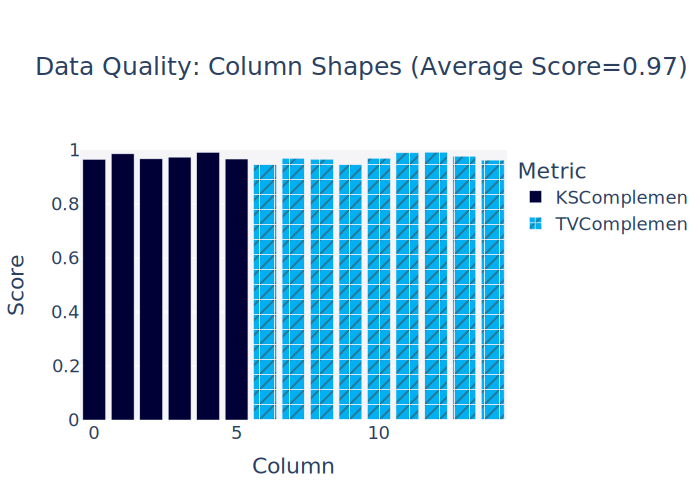

In [7]:
fig = qual_report.get_visualization(property_name='Column Shapes')
fig.show(renderer = 'svg')

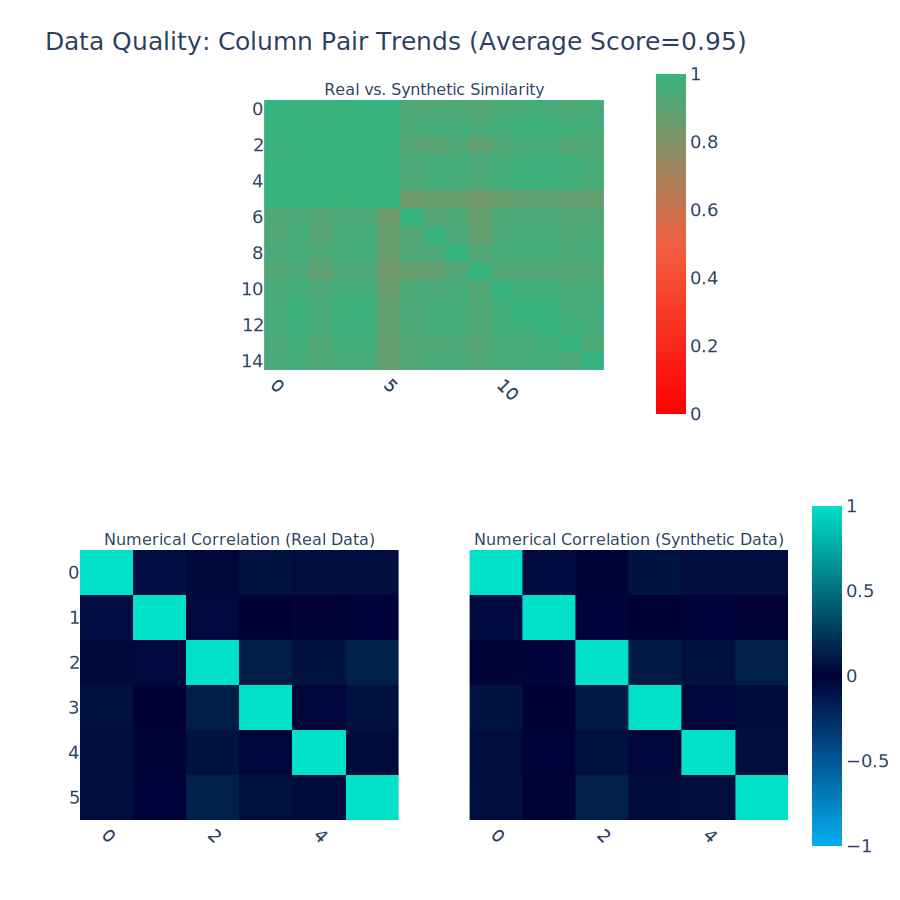

In [9]:
fig = qual_report.get_visualization(property_name='Column Pair Trends')
fig.show(renderer = 'svg')

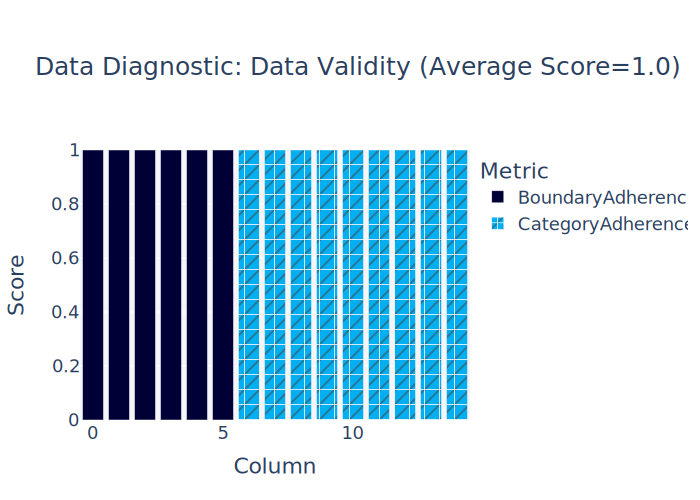

In [11]:
fig = diag_report.get_visualization(property_name = 'Data Validity')
fig.show(renderer = 'svg')

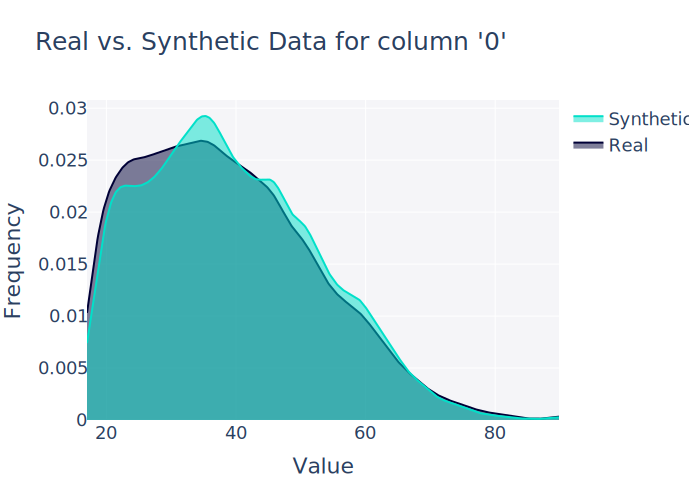

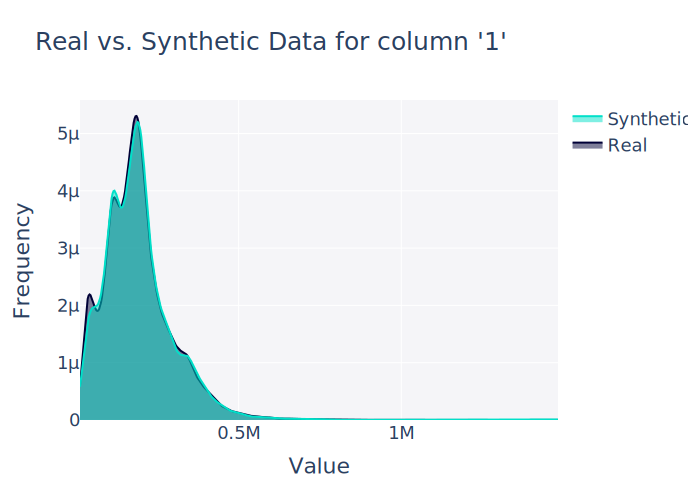

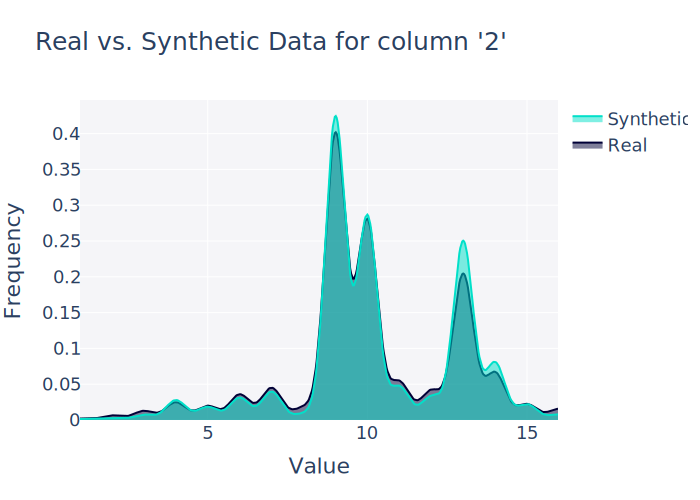

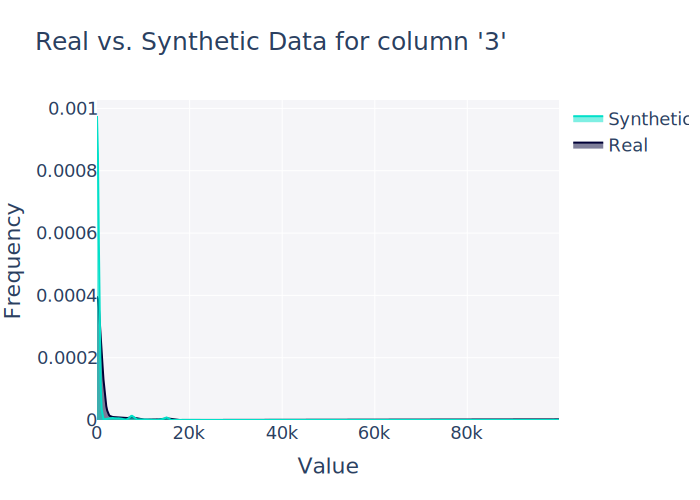

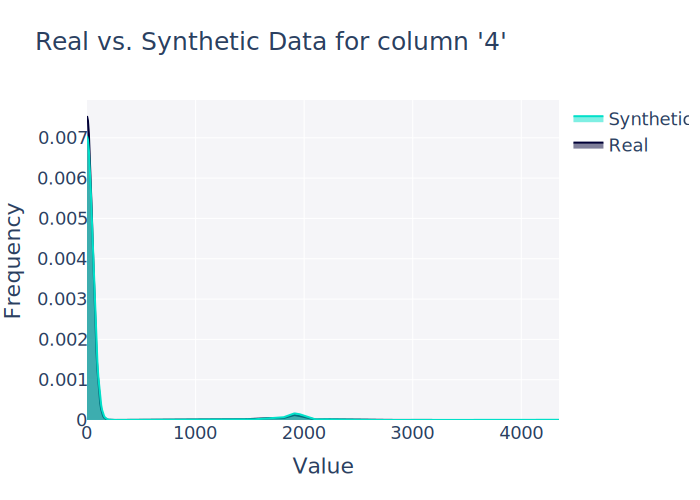

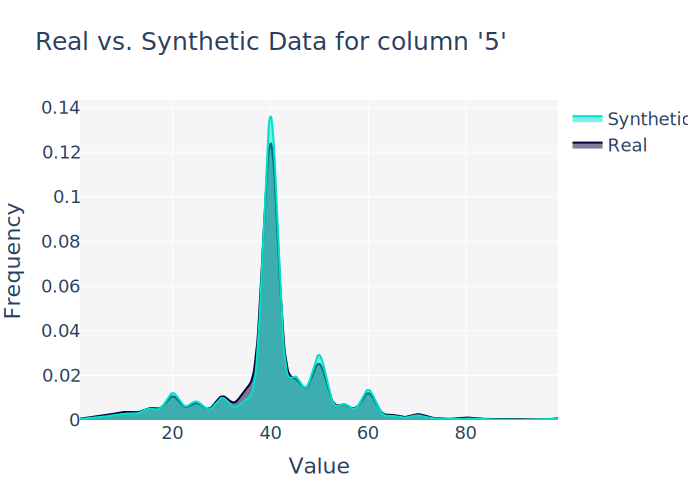

In [10]:
from sdmetrics.visualization import get_column_plot
for i in range(0, 6):
    fig = get_column_plot(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        column_name= i,
        plot_type='distplot'
    )

    fig.show(renderer = 'svg')